In [1]:
import sqlite3
from datetime import datetime

Создание БД

In [2]:
conn = sqlite3.connect('data_for_20.db')
c = conn.cursor()

In [3]:
books = [(1, 'Marcel Proust', 'In Search of Lost Time', 1913),
         (2, 'James Joyce', 'Ulysses', 1904),
         (3, 'Miguel de Cervantes', 'Don Quixote Part1', 1612),
         (4, 'Miguel de Cervantes', 'Don Quixote Part2', 1620),
         (5, 'F. Scott Fitzgerald', 'The Great Gatsby', 1925)]

In [4]:
c.execute('''CREATE TABLE books (
            id INT PRIMARY KEY NOT NULL, 
            author TEXT NOT NULL, 
            title TEXT NOT NULL, 
            publish_year INT NOT NULL
            )''')

In [5]:
c.executemany('''INSERT INTO books VALUES (?, ?, ?, ?)''', books)

conn.commit()

In [6]:
readers = [(1, 'John Brown'),
           (2, 'Mary Crown'),
           (3, 'Nicolas Cage'),
           (4, 'Ann Burnington'),
           (5, 'Lily Hook')]

In [7]:
c.execute('''CREATE TABLE readers (
            id INT PRIMARY KEY NOT NULL,
            name TEXT NOT NULL
            )''')

In [8]:
c.executemany('''INSERT INTO readers VALUES (?, ?)''', readers)

conn.commit()

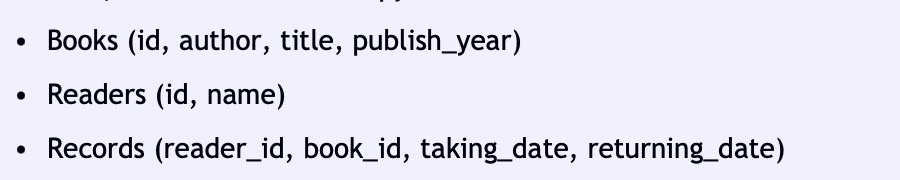

In [9]:
records = [(1, 1, '2023-10-01', None),
           (2, 2, '2019-06-01', '2019-07-01'),
           (3, 3, '2020-04-03', '2021-01-20'),
           (4, 4, '2021-09-15', '2022-05-20'),
           (5, 5, '2017-04-10', '2017-07-15')]

In [10]:
c.execute('''CREATE TABLE records (
            reader_id INT NOT NULL,
            book_id INT NOT NULL, 
            taking_date TEXT NOT NULL, 
            returning_date TEXT,
            FOREIGN KEY (reader_id) REFERENCES readers (id)
            FOREIGN KEY (book_id) REFERENCES books (id)
            )''')

In [11]:
c.executemany('''INSERT INTO records VALUES (?, ?, ?, ?)''', records)

conn.commit()

In [12]:
conn.close()

In [13]:
class library_db:

    def __init__(self, path_to_db):
        self.conn = sqlite3.connect(path_to_db)

        self.book_ids = []
        for book_id in self.conn.execute('select id from books'):
            self.book_ids.append(book_id[0])
        
        self.reader_ids = []
        for reader_id in self.conn.execute('select id from readers'):
            self.reader_ids.append(reader_id[0])

    def close(self):
        self.conn.close()
    
    def get_books(self):
        return self.conn.execute('select author, title, publish_year from books').fetchall()
    
    def get_readers(self):
        return self.conn.execute('select name from readers').fetchall()
    
    def add_book(self, author: str, title: str, publish_year: int):

        if publish_year > datetime.now().year:
            raise ValueError('Oh, you are from the future! Elon Musk colonized Mars?')
        
        if self.conn.execute(f"select id from books where author = '{author}' and title = '{title}'").fetchone():
            raise AttributeError('Our database already contains such a book')
        
        new_book_id = max(self.book_ids) + 1
        self.conn.execute('insert into books values (?, ?, ?, ?)',
                           (new_book_id, author, title, publish_year))
        self.book_ids.append(new_book_id)
        self.conn.commit()
    
    def add_reader(self, name: str):

        if self.conn.execute(f"select id from readers where name = '{name}'").fetchone():
            raise AttributeError('You are already registered in our library, if you want to make a donation, then just transfer the money to our account')
        
        new_reader_id = max(self.reader_ids) + 1
        self.conn.execute('insert into readers values (?, ?)',
                           (new_reader_id, name))
        self.reader_ids.append(new_reader_id)
        self.conn.commit()
    
    def lend_book(self, author: str, title: str, name: str,
                  taking_date: str = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}',
                  returning_date: str = None):
        
        try:
            reader_id = self.conn.execute(f"select id from readers where name = '{name}'").fetchone()[0]
        except:
            raise AttributeError('You are not registered in our library, pay a membership fee to use our services')
        
        try:
            book_id = self.conn.execute(f"select id from books where author = '{author}' and title = '{title}'").fetchone()[0]
        except:
            raise AttributeError('We do not currently have such a book, but you can donate it to us when you buy it in the store')
        
        check = self.conn.execute(f"select taking_date, returning_date from records where reader_id = '{reader_id}' and book_id = '{book_id}'").fetchall()
        if check:
            if not check[-1][1]:
                raise AttributeError('You have already borrowed this book from us, have you lost it?')
        
        self.conn.execute('insert into records values (?, ?, ?, ?)',
                          (reader_id, book_id, taking_date, returning_date))
        
        self.conn.commit()
    
    def return_book(self, author: str, title: str, name: str,
                    returning_date: str = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}'):
        try:
            reader_id = self.conn.execute(f"select id from readers where name = '{name}'").fetchone()[0]
        except:
            raise AttributeError('You are not registered in our library, pay a membership fee to use our services. You can also donate this book to us.')
        
        try:
            book_id = self.conn.execute(f"select id from books where author = '{author}' and title = '{title}'").fetchone()[0]
        except:
            raise AttributeError('This book does not belong to our library, but you can donate it to us')
        
        check = self.conn.execute(f"select taking_date, returning_date from records where reader_id = '{reader_id}' and book_id = '{book_id}'").fetchall()
        if check:
            if check[-1][1]:
                raise AttributeError('This is your book, but you can give it to us')
            else:
                taking_date = check[-1][0]
                self.conn.execute(f"delete from records where reader_id = '{reader_id}' and book_id = '{book_id}'")
                self.conn.execute('insert into records values (?, ?, ?, ?)',
                                  (reader_id, book_id, taking_date, returning_date))
                self.conn.commit()
        else:
            raise AttributeError('This is your book, but you can give it to us')

In [14]:
library = library_db('data_for_20.db')

In [15]:
library.get_books()

[('Marcel Proust', 'In Search of Lost Time', 1913),
 ('James Joyce', 'Ulysses', 1904),
 ('Miguel de Cervantes', 'Don Quixote Part1', 1612),
 ('Miguel de Cervantes', 'Don Quixote Part2', 1620),
 ('F. Scott Fitzgerald', 'The Great Gatsby', 1925)]

In [16]:
library.get_readers()

[('John Brown',),
 ('Mary Crown',),
 ('Nicolas Cage',),
 ('Ann Burnington',),
 ('Lily Hook',)]

In [17]:
library.add_book('Herman Melville', 'Moby Dick', 2050)

ValueError: Oh, you are from the future! Elon Musk colonized Mars?

In [19]:
library.add_book('Herman Melville', 'Moby Dick', 1851)

In [20]:
library.get_books()

[('Marcel Proust', 'In Search of Lost Time', 1913),
 ('James Joyce', 'Ulysses', 1904),
 ('Miguel de Cervantes', 'Don Quixote Part1', 1612),
 ('Miguel de Cervantes', 'Don Quixote Part2', 1620),
 ('F. Scott Fitzgerald', 'The Great Gatsby', 1925),
 ('Herman Melville', 'Moby Dick', 1851)]

In [21]:
library.lend_book('James Joyce', 'Ulysses', 'John Brown')

In [22]:
library.conn.execute('select * from records').fetchall()[-1]

(1, 2, '2023-5-22', None)

In [23]:
library.return_book('James Joyce', 'Ulysses', 'John Brown')

In [25]:
library.conn.execute('select * from records').fetchall()

[(1, 1, '2023-10-01', None),
 (2, 2, '2019-06-01', '2019-07-01'),
 (3, 3, '2020-04-03', '2021-01-20'),
 (4, 4, '2021-09-15', '2022-05-20'),
 (5, 5, '2017-04-10', '2017-07-15'),
 (1, 2, '2023-5-22', '2023-5-22')]

In [26]:
library.return_book('James Joyce', 'Ulysses', 'John Brown')

AttributeError: This is your book, but you can give it to us